In [55]:
#load the file and begin to explore attributes.

import pandas as pd
import numpy as np
import datetime as dt
import plotly as ply
from sklearn.model_selection import ShuffleSplit as ss
from sklearn.linear_model import LogisticRegression as lr
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler as sts
from sklearn.pipeline import Pipeline as pl
from matplotlib import pyplot as plt
from __future__ import print_function as pr

#load pre-generated rainfall.csv file
rainfall = pd.read_csv('rainfall.csv', index_col=0) 

In [56]:
rainfall = rainfall.drop(['Evaporation', 'Sunshine'], axis = 1) #dropped variable becuase there are too many NaN's
l = list(rainfall.Location.unique())
rainfall.dropna(subset = list(rainfall), inplace = True) #dropped city becuase variable was not recorded by said city
#check to see which city was droped
for i in l:
    if i not in rainfall.Location.unique():
        print(i)
rainfall = rainfall.drop(['Date', 'Location'], axis = 1) #not needed for prediction


BadgerysCreek
Newcastle
NorahHead
Penrith
Tuggeranong
MountGinini
Nhil
Dartmoor
GoldCoast
Adelaide
Albany
Witchcliffe
SalmonGums
Walpole


In [57]:
#Sanity Check

rainfall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101328 entries, 0 to 140786
Data columns (total 19 columns):
MinTemp          101328 non-null float64
MaxTemp          101328 non-null float64
Rainfall         101328 non-null float64
WindGustDir      101328 non-null float64
WindGustSpeed    101328 non-null float64
WindDir9am       101328 non-null float64
WindDir3pm       101328 non-null float64
WindSpeed9am     101328 non-null float64
WindSpeed3pm     101328 non-null float64
Humidity9am      101328 non-null float64
Humidity3pm      101328 non-null float64
Pressure9am      101328 non-null float64
Pressure3pm      101328 non-null float64
Cloud9am         101328 non-null float64
Cloud3pm         101328 non-null float64
Temp9am          101328 non-null float64
Temp3pm          101328 non-null float64
RainToday        101328 non-null int64
RainTomorrow     101328 non-null int64
dtypes: float64(17), int64(2)
memory usage: 15.5 MB


In [58]:
rainfall.describe()

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000,101328.000000
mean,12.555004,23.785175,2.310124,168.031238,40.454275,160.176695,169.715965,14.742669,19.219872,67.325690,49.447773,1017.432259,1015.011117,4.630442,4.536538,17.392894,22.300069,0.214038,0.211748
std,6.560254,7.191132,8.735983,100.158705,13.457190,102.693873,100.901504,8.722084,8.631695,19.235662,20.765612,7.056431,6.983109,2.872467,2.684587,6.658633,7.008942,0.410155,0.408549
min,-8.000000,4.100000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-2.300000,1.700000,0.000000,0.000000
25%,7.700000,18.200000,0.000000,90.000000,31.000000,67.500000,90.000000,9.000000,13.000000,55.000000,34.000000,1012.800000,1010.300000,1.437500,2.000000,12.300000,16.900000,0.000000,0.000000
50%,12.300000,23.200000,0.000000,157.500000,39.000000,157.500000,180.000000,13.000000,19.000000,69.000000,50.000000,1017.300000,1015.000000,5.187500,5.000000,17.000000,21.800000,0.000000,0.000000
75%,17.400000,29.200000,0.600000,247.500000,48.000000,247.500000,247.500000,20.000000,24.000000,81.000000,64.000000,1022.100000,1019.700000,7.000000,7.000000,22.300000,27.400000,0.000000,0.000000
max,31.900000,48.100000,371.000000,337.500000,135.000000,337.500000,337.500000,87.000000,76.000000,100.000000,100.000000,1040.600000,1039.600000,9.000000,9.000000,40.200000,46.700000,1.000000,1.000000


# Training and Testing Split

In [64]:
#Create the numpy matrices for the prediction of "RainTomorrow"

if 'RainTomorrow' in rainfall:
    y= rainfall['RainTomorrow'].values
    del rainfall['RainTomorrow']
    x=rainfall.values

#Set-up to use scikit learn to create training and test splits

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations, test_size = 0.2)

print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


# Support Vector Machines 

In [65]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

In [61]:
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.8599131550379947
[[15465   553]
 [ 2286  1962]]


In [62]:
#Look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(26495, 18)
(26495,)
[13560 12935]


In [66]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
rainfall_tested_on = rainfall.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
rainfall_support = rainfall_tested_on.iloc[svm_clf.support_,:]

rainfall_support['RainTomorrow'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
rainfall['RainTomorrow'] = y # also add it back in for the original data
rainfall_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26495 entries, 53520 to 7655
Data columns (total 19 columns):
MinTemp          26495 non-null float64
MaxTemp          26495 non-null float64
Rainfall         26495 non-null float64
WindGustDir      26495 non-null float64
WindGustSpeed    26495 non-null float64
WindDir9am       26495 non-null float64
WindDir3pm       26495 non-null float64
WindSpeed9am     26495 non-null float64
WindSpeed3pm     26495 non-null float64
Humidity9am      26495 non-null float64
Humidity3pm      26495 non-null float64
Pressure9am      26495 non-null float64
Pressure3pm      26495 non-null float64
Cloud9am         26495 non-null float64
Cloud3pm         26495 non-null float64
Temp9am          26495 non-null float64
Temp3pm          26495 non-null float64
RainToday        26495 non-null int64
RainTomorrow     26495 non-null int64
dtypes: float64(17), int64(2)
memory usage: 4.0 MB


C:\Users\jodip\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



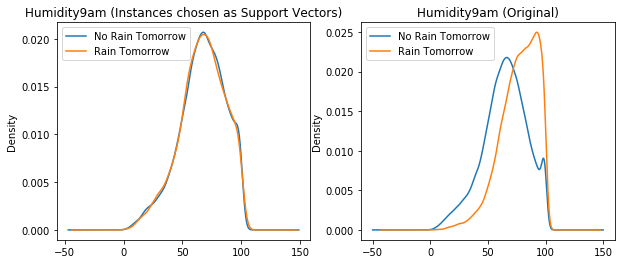

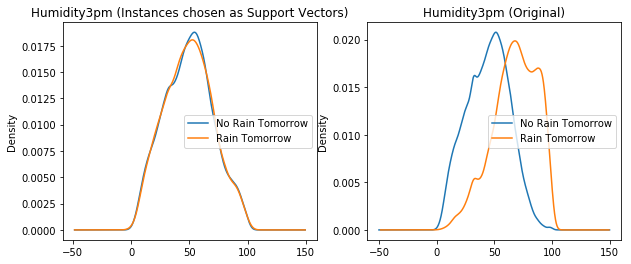

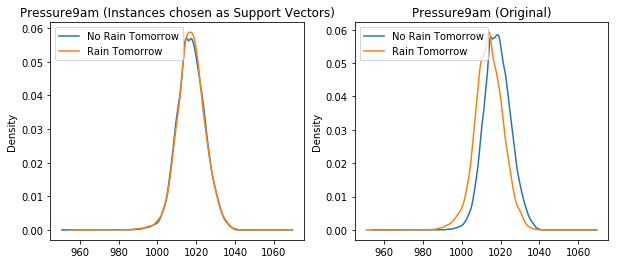

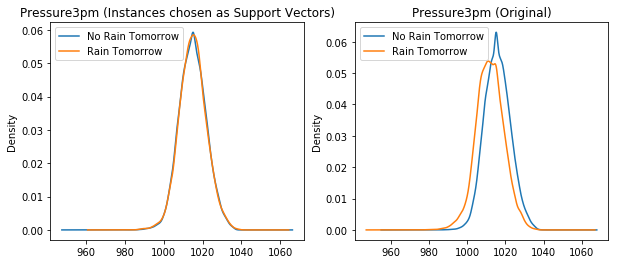

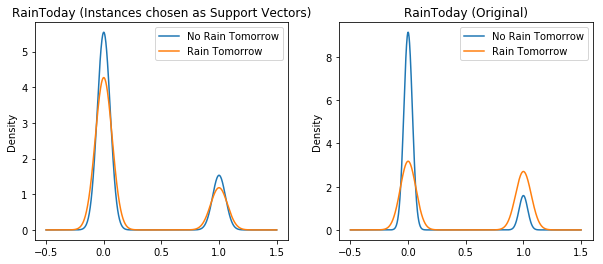

In [67]:
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
rainfall_grouped_support = rainfall_support.groupby(['RainTomorrow'])
rainfall_grouped = rainfall.groupby(['RainTomorrow'])

# plot KDE of Different variables
vars_to_plot = ['Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','RainToday']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = rainfall_grouped_support[v].plot.kde() 
    plt.legend(['No Rain Tomorrow','Rain Tomorrow'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = rainfall_grouped[v].plot.kde() 
    plt.legend(['No Rain Tomorrow','Rain Tomorrow'])
    plt.title(v+' (Original)')